In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
import pdb
%matplotlib inline

tfe.enable_eager_execution()

In [3]:
mnist = input_data.read_data_sets('..\datasets\MNIST_data')

Extracting ..\datasets\MNIST_data\train-images-idx3-ubyte.gz
Extracting ..\datasets\MNIST_data\train-labels-idx1-ubyte.gz
Extracting ..\datasets\MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ..\datasets\MNIST_data\t10k-labels-idx1-ubyte.gz


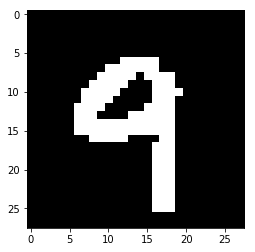

In [4]:
plt.rcParams['image.cmap'] = 'gray'
sample_img = mnist.train.images[8]
sample_img = (sample_img > 0).astype(np.float32)
plt.imshow(sample_img.reshape([28, 28]))

In [5]:
class RBM:
    def __init__(self, visible_dim, hidden_dim):
        self.visible_dim = visible_dim
        self.hidden_dim = hidden_dim
        
        # initiating weight variables
        self.W = tf.Variable(np.random.normal(loc=0., scale=0.1, size=(visible_dim, hidden_dim)), dtype=tf.float32)
        self.c = tf.Variable(np.ones((visible_dim, 1)), dtype=tf.float32)
        self.b = tf.Variable(np.ones((hidden_dim, 1)), dtype=tf.float32)
    
    
    def energy(self, x, h):
        e = tf.matmul(tf.matmul(x, self.W), tf.transpose(h))
        e = tf.diag_part(e) + tf.matmul(x, self.c) + tf.matmul(h, self.b)
        e = e / tf.cast(tf.shape(x)[0], dtype=tf.float32)
        return -1 * e
    
    
    def prob_of_h_given_x(self, x):
        """
        Input shape
            x:  N * V
        """
        
        tensor_x = tf.convert_to_tensor(x, dtype=tf.float32)
        return tf.sigmoid(tf.matmul(tensor_x, self.W) + tf.transpose(self.b))  
    
    
    def prob_of_x_given_h(self, h):
        """
        Input shape
            h:  N * H
        """
        
        tensor_h = tf.convert_to_tensor(h, dtype=tf.float32)
        return tf.sigmoid(tf.matmul(tensor_h, tf.transpose(self.W)) + tf.transpose(self.c))    
    
    
    def sample_from_dist(self, dist):
        sample = tf.random.uniform(minval=0, maxval=1, shape=dist.shape)
        return tf.cast((dist > sample), dtype=tf.float32)
    
    
    def gibbs_sampler(self, x, k=1, sample=True, return_prob=False):
        x_tilde = x
        
        for _ in range(k):
            h_dist = self.prob_of_h_given_x(x_tilde)
            if sample:
                h = self.sample_from_dist(h_dist)
            else:
                h = h_dist
            
            x_dist = self.prob_of_x_given_h(h)
            if sample:
                x_tilde = self.sample_from_dist(x_dist)
            else:
                x_tilde = x_dist
        
        if return_prob:
            return x_dist
        else:
            return self.sample_from_dist(x_dist)
    
    
    def update_weights(self, x, learning_rate=0.005, **kargs):
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        batch_size = tf.cast(tf.shape(x)[0], dtype=tf.float32)
        
        x_tilde = self.gibbs_sampler(x, **kargs)
        h_tilde_of_x = self.prob_of_h_given_x(x)
        h_tilde_of_x_tilde = self.prob_of_h_given_x(x_tilde)
        
        with tf.GradientTape(persistent=True) as tape:
            possitive_energy = self.energy(x, h_tilde_of_x)
            negative_energy = self.energy(x_tilde, h_tilde_of_x_tilde)
        
        grad_W = (tape.gradient(possitive_energy, self.W) - tape.gradient(negative_energy, self.W)) / batch_size
        grad_b = (tape.gradient(possitive_energy, self.b) - tape.gradient(negative_energy, self.b)) / batch_size
        grad_c = (tape.gradient(possitive_energy, self.c) - tape.gradient(negative_energy, self.c)) / batch_size
          
        self.W.assign_sub(learning_rate * grad_W)
        self.c.assign_sub(learning_rate * grad_c)
        self.b.assign_sub(learning_rate * grad_b) 
#         pdb.set_trace()

In [6]:
class DBN:
    def __init__(self, input_dims, layers, *args, **kargs):
        self.input_dims = input_dims
        self.layers = []
        
        cur_input_dims = input_dims
        for hidden_dim in layers:
            rbm = RBM(cur_input_dims, hidden_dim)
            self.layers.append(rbm)
            cur_input_dims = hidden_dim
        
        self.rbm = self.layers[-1]
        
    def sample_from_dist(self, dist):
        sample = tf.random.uniform(minval=0, maxval=1, shape=dist.shape)
        return tf.cast((dist > sample), dtype=tf.float32)
    
    def train(self, x, learning_rate=0.005, **kargs):
        inputs = x
        
        for i, layer in enumerate(self.layers):
            layer.update_weights(inputs, learning_rate=learning_rate, **kargs)
            
            if i < len(self.layers) - 1:
                prob_h_i = layer.prob_of_h_given_x(inputs)
                h_i = layer.sample_from_dist(prob_h_i)
                
                inputs = h_i
                
    def generate(self, n, k=100, sample=True, return_prob=False):
        inputs = np.random.randint(2, size=(n, self.rbm.visible_dim))
        
        random_sample_x = self.rbm.gibbs_sampler(inputs, k=k, sample=True, return_prob=False)
        input_h = self.sample_from_dist(self.rbm.prob_of_h_given_x(random_sample_x))
        
        x_dist = None
        for layer in reversed(self.layers):
            x_dist = layer.prob_of_x_given_h(input_h)
            if sample:
                input_h = self.sample_from_dist(x_dist)
            else:
                input_h = x_dist
        
        if return_prob:
            return x_dist
        else:
            return self.sample_from_dist(x_dist)

In [9]:
def toBinary(X):
    return (X > 0).astype(np.float32)


epoch = 50
batch_size = 500
max_iter = int(mnist.train.num_examples/batch_size)

CD_k = 1
visable_layers = mnist.train.images.shape[1]
layers = [512, 512, 128, 128, 64, 64]
dbm = DBN(visable_layers, layers)

for e in range(epoch):
    for it in range(max_iter):
        batch_x, _ = mnist.train.next_batch(batch_size)
        binary_batch_x = toBinary(batch_x)
        dbm.train(binary_batch_x, k=CD_k)

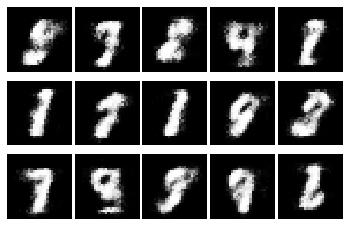

In [12]:
import matplotlib.gridspec as gridspec


def show_images(images, rows):
    rows = rows
    cols = int(images.shape[0]/rows)
    image_width = image_height = np.ceil(np.sqrt(images.shape[1])).astype(int)
    
#     plt.figure(figsize=(5, 5))
    gs = gridspec.GridSpec(rows, cols)
    gs.update(wspace=0.05, hspace=0.05)
    
    for i in range(images.shape[0]):
        axs = plt.subplot(gs[i])
        axs.axis('off')
        axs.set_xticklabels([])
        axs.set_yticklabels([])
        axs.imshow(images[i].reshape([image_width, image_height]))


generated_images = dbm.generate(15, return_prob=True).numpy()
show_images(generated_images, 3)